# 딥러닝2022 중간고사 (ver 0.5) 

In [1]:
import torch 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import time
from fastai.vision.all import *

In [2]:
import graphviz
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"'+s + '; }');

In [ ]:
#hide
graphviz.set_jupyter_format('png')

'svg'

## `1`. 크롤링을 통한 이미지 분석 및 CAM (50점)

`(1)` 두 가지 키워드로 크롤링을 수행하여 이미지자료를 모아라. (키워드는 {'iu','hynn'}을 제외하고 본인이 선택할 것) // 5점

In [29]:
# 크롤링에 필요한 준비작업들
!pip install -Uqq duckduckgo_search
from duckduckgo_search import ddg_images
from fastdownload import download_url
from fastcore.all import *
def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [30]:
# 폴더만드는코드 -- 사실 손으로 만들어도 무방함.. 
!mkdir images
!mkdir images/train
!mkdir images/test 
!mkdir images/train/guitar
!mkdir images/train/cello
!mkdir images/test/guitar
!mkdir images/test/cello

In [31]:
download_images(dest='./images/train/guitar',urls=search_images('guitar',max_images=200)) # guitar 라는 키워드로 200개 이미지 크롤링 -> ./images/train/suzy 에 저장
time.sleep(10) # 서버과부하를 위한 휴식코드 
download_images(dest='./images/train/cello',urls=search_images('cello',max_images=200)) # cello 이라는 키워드로 200개 이미지 크롤링 -> ./images/train/jennie 에 저장
time.sleep(10) # 서버과부하를 위한 휴식코드 

In [32]:
download_images(dest='./images/test/guitar',urls=search_images('guitar photo',max_images=50)) # guitar photo 라는 키워드로 50개 이미지 크롤링 -> ./images/test/suzy 에 저장
time.sleep(10) # 서버과부하를 위한 휴식코드 
download_images(dest='./images/test/cello',urls=search_images('cello photo',max_images=50)) # cello photo 라는 키워드로 50개 이미지 크롤링 -> ./images/test/jennie 에 저장 
time.sleep(10) # 서버과부하를 위한 휴식코드 


In [33]:
# 불량 이미지 삭제
bad_images = verify_images(get_image_files('./images'))
bad_images


(#8) [Path('images/train/cello/9db7861d-ef18-41a8-8022-37b827f09220.jpg'),Path('images/train/cello/b61f8351-330c-418b-90f7-0306cf7c5726.jpg'),Path('images/train/cello/8ac2bd35-15b9-4705-841a-3b8fc2ec4c10.jpg'),Path('images/train/cello/b5cc7aea-c98e-483c-9d61-74a35f59cdd8.jpg'),Path('images/train/cello/bd1942ce-5639-4fdf-ba80-144c4c0506ca.jpg'),Path('images/train/guitar/3ea78687-2b9d-475d-936c-99ef32191f08.jpg'),Path('images/test/cello/d3863d17-78a4-4aa3-ab3b-0ca238b09267.jpg'),Path('images/test/guitar/91e8dc9f-664d-4f0a-91b6-029a38ee8287.jpg')]

In [34]:
# 불량 이미지 목록
bad_images.map(Path.unlink)


(#8) [None,None,None,None,None,None,None,None]

`(2)` ImageDataLoaders.from_folder 를 이용하여 dls를 만들어라. // 5점

In [35]:
dls = ImageDataLoaders.from_folder(path = './images', train='train',valid='test',item_tfms=Resize(512),bs=8) 

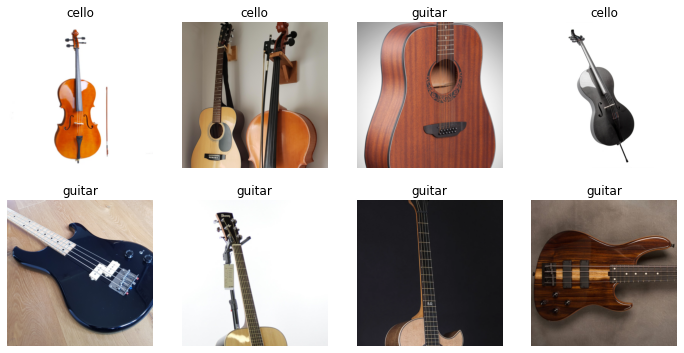

In [36]:
dls.show_batch()

`(3)` resnet34를 이용하여 학습하라. // 5점

In [37]:
lrnr = vision_learner(dls , resnet34 , metrics = accuracy) 

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [38]:
lrnr.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.552819,0.006740,1.000000,00:47


epoch,train_loss,valid_loss,accuracy,time
0,0.083335,0.079592,0.989583,00:38


`(4)` CAM (class activation mapping)을 이용하여 (3)의 모형의 판단근거를 시각화하라. // 35점

In [39]:
## CAM 구현
# 1.이미지 분류 잘하는 네트워크 선택
# 2. 네트워크 끝 부분 수정

In [40]:
len(lrnr.model) 

2

In [41]:
# 네트워크의 길이기 2이므로 네트워크를 분리한다.
net1 = lrnr.model[0]
net2 = lrnr.model[1]
net2 # 끝 부분 수정을 위해 마지막 부분 네트워크 확인

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

In [42]:
# 네트워크 수정
net2 = torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(output_size = 1),
    torch.nn.Flatten(), 
    torch.nn.Linear(512,2,bias = False)
)

In [43]:
# 새로운 네트워크
net = torch.nn.Sequential(
    net1, 
    net2
) 

In [44]:
lrnr2 = Learner(dls,net, metrics = accuracy)

In [45]:
lrnr2.loss_func  # CrossEntropyLoss()로 잘 들어가있음.

FlattenedLoss of CrossEntropyLoss()

In [46]:
lrnr2.fine_tune(7) ## 재학습

epoch,train_loss,valid_loss,accuracy,time
0,0.475098,14.393646,0.364583,00:40


epoch,train_loss,valid_loss,accuracy,time
0,0.360586,1.163153,0.885417,00:36
1,0.277121,0.333100,0.895833,00:42
2,0.319795,0.343611,0.875000,00:43
3,0.326704,0.182674,0.968750,00:41
4,0.265613,0.205462,0.937500,00:40
5,0.267080,0.122911,0.968750,00:37
6,0.195307,0.099364,0.968750,00:40


In [52]:
# 3. Linear와 Ap의 순서 바꾸기
ximg = PILImage.create('/content/images/train/cello/0eff8b3a-a5c7-44b6-90ad-b418f3502e5b.jpg')
x = first(dls.test_dl([ximg]))[0]

In [53]:
x.shape

torch.Size([1, 3, 512, 512])

In [54]:
net2   # 원래 순서 net2[2](net2[1](net2[0](net1(x))))

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=512, out_features=2, bias=False)
)

In [55]:
print(net1(x).shape)
print(net2[0](net1(x)).shape)
print(net2[1](net2[0](net1(x))).shape)
print(net2[2](net2[1](net2[0](net1(x)))).shape)

torch.Size([1, 512, 16, 16])
torch.Size([1, 512, 1, 1])
torch.Size([1, 512])
torch.Size([1, 2])


In [56]:
net(x)

TensorImage([[ 0.8878, -0.9712]], device='cuda:0', grad_fn=<AliasBackward0>)

In [57]:
dls.vocab # 이미지 x는  cello이다.

['cello', 'guitar']

In [58]:
(net2[2].weight).shape , net1(x).shape

(torch.Size([2, 512]), torch.Size([1, 512, 16, 16]))

In [59]:
why = torch.einsum('cb,abij->acij',net2[2].weight,net1(x))

In [60]:
net2[1](net2[0](why))

TensorImage([[ 0.8878, -0.9712]], device='cuda:0', grad_fn=<AliasBackward0>)

In [61]:
net(x) 

TensorImage([[ 0.8878, -0.9712]], device='cuda:0', grad_fn=<AliasBackward0>)

In [62]:
# 4. CAM 시각화
print((why[0,0,:,:]).mean()) # 값이 큰 곳이 첼로를 특정한다.
print((why[0,1,:,:]).mean()) # 값이 큰 곳이 기타를 특정한다.

TensorImage(0.8878, device='cuda:0', grad_fn=<AliasBackward0>)
TensorImage(-0.9712, device='cuda:0', grad_fn=<AliasBackward0>)


In [63]:
why_cello = why[0,0,:,:]
why_guitar= why[0,1,:,:]

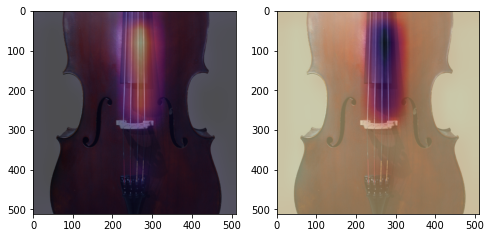

In [64]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(torch.einsum('ocij -> ijc',dls.decode((x,))[0]).to("cpu"))
ax[0].imshow(why_cello.to("cpu").detach(),cmap='magma',extent=(0,511,511,0),interpolation='bilinear',alpha=0.5)
ax[1].imshow(torch.einsum('ocij -> ijc',dls.decode((x,))[0]).to("cpu"))
ax[1].imshow(why_guitar.to("cpu").detach(),cmap='magma',extent=(0,511,511,0),interpolation='bilinear',alpha=0.5)

In [65]:
path = '/content/images'

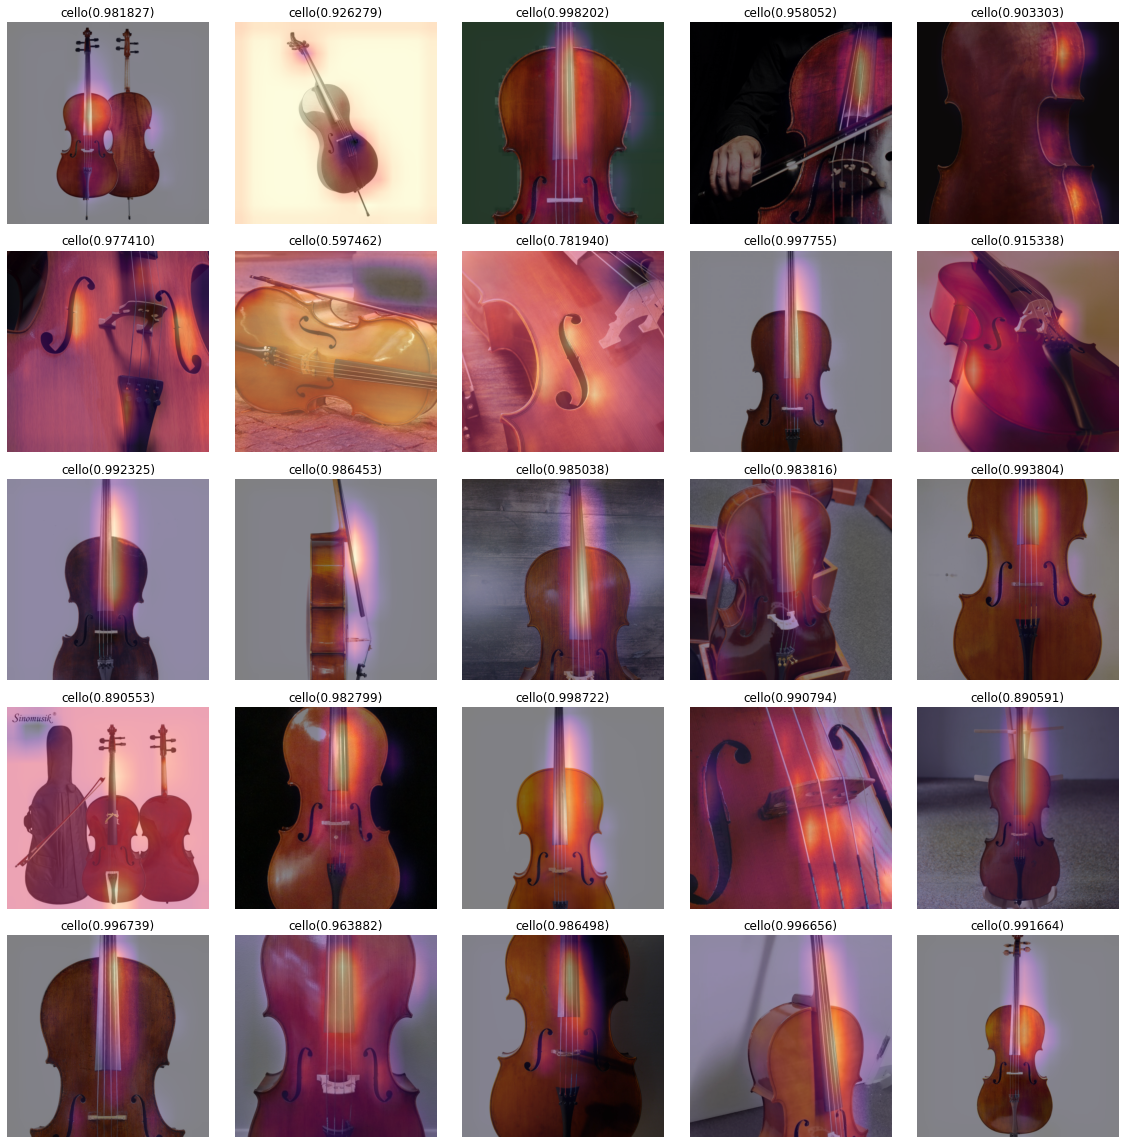

In [66]:
sftmax = torch.nn.Softmax(dim=1)
fig, ax = plt.subplots(5,5) 
k=0 
for i in range(5):
    for j in range(5): 
        x, = first(dls.test_dl([PILImage.create(get_image_files(path)[k])]))
        why = torch.einsum('cb,abij -> acij', net2[2].weight, net1(x))
        why_cello = why[0,0,:,:] 
        why_guitar = why[0,1,:,:] 
        celloprob, guitarprob = sftmax(net(x))[0][0].item(), sftmax(net(x))[0][1].item()
        if celloprob>guitarprob: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(why_cello.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("cello(%2f)" % celloprob)
        else: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(why_guitar.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("guitar(%2f)" % guitarprob)
        k=k+1 
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()

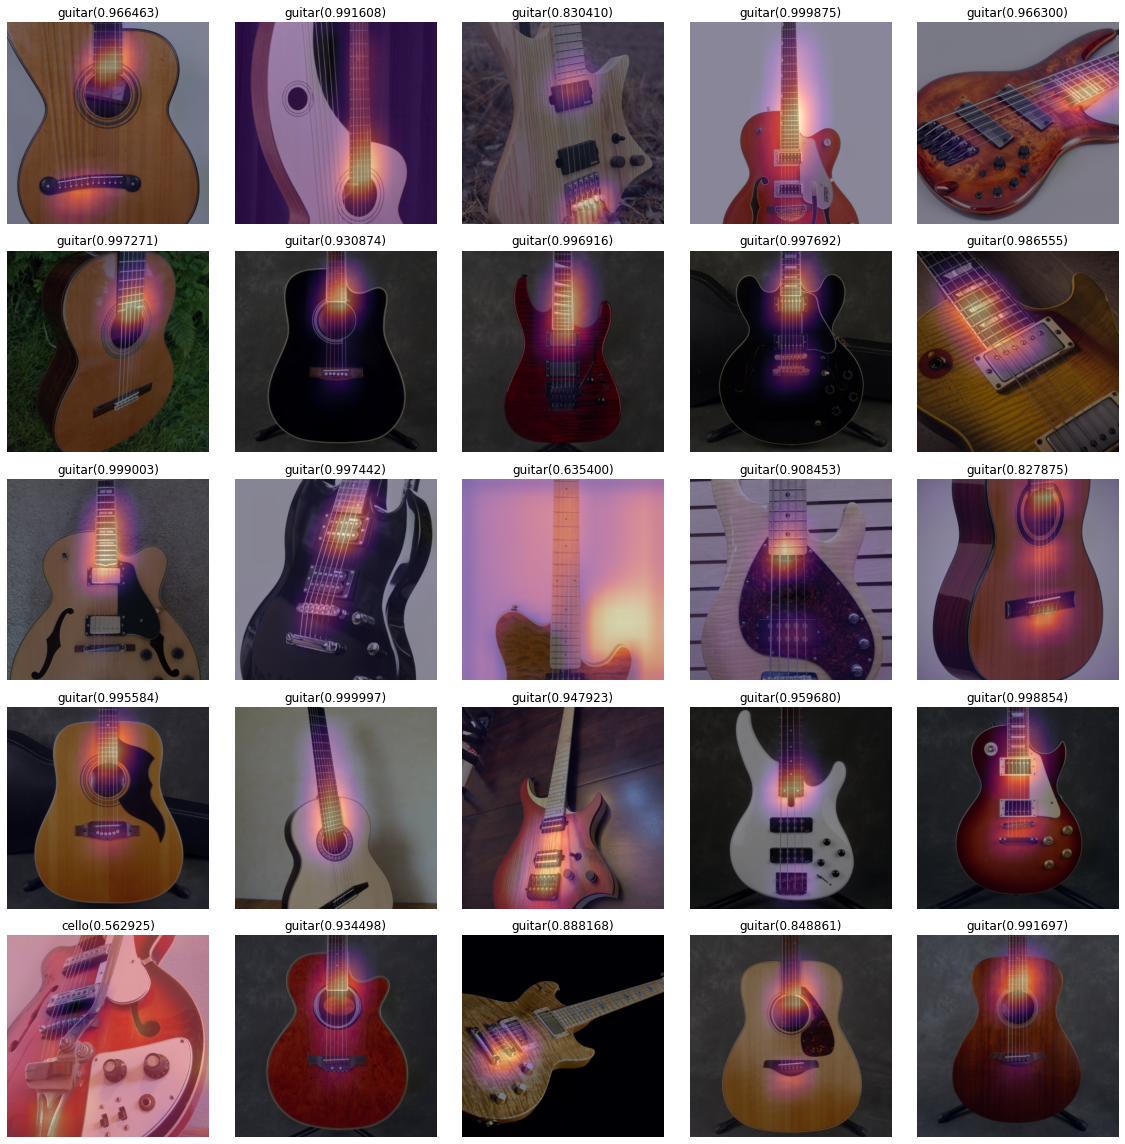

In [69]:
fig, ax = plt.subplots(5,5) 
k=200
for i in range(5):
    for j in range(5): 
        x, = first(dls.test_dl([PILImage.create(get_image_files(path)[k])]))
        why = torch.einsum('cb,abij -> acij', net2[2].weight, net1(x))
        why_cello = why[0,0,:,:] 
        why_guitar = why[0,1,:,:] 
        celloprob, guitarprob = sftmax(net(x))[0][0].item(), sftmax(net(x))[0][1].item()
        if celloprob>guitarprob: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(why_cello.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("cello(%2f)" % celloprob)
        else: 
            dls.train.decode((x,))[0].squeeze().show(ax=ax[i][j])
            ax[i][j].imshow(why_guitar.to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='magma')
            ax[i][j].set_title("guitar(%2f)" % guitarprob)
        k=k+1 
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()

In [80]:
# 기타 사진에서 밝은 부분이 기타를 특정하고, 첼로 사진에서 밝은 부분이 첼로를 특정한다

## `2`. (30점)

In [3]:
torch.manual_seed(7676)
x = torch.randn(100).sort().values
ϵ = torch.randn(100)*0.5
y = 2.5+ 4*x + ϵ

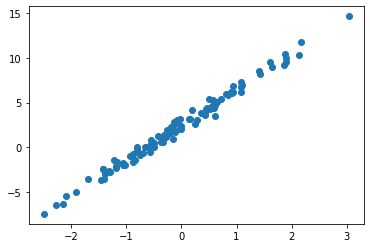

In [4]:
plt.plot(x,y,'o')

In [5]:
x.shape , y.shape

(torch.Size([100]), torch.Size([100]))

In [10]:
_1 = torch.ones([100,1])
x = x.reshape(-1,1)
y = y.reshape(-1,1)
X = torch.concat([_1 , x], axis =1 )

In [11]:
X.shape , y.shape

(torch.Size([100, 2]), torch.Size([100, 1]))

In [15]:
## (1)
torch.manual_seed(43052)
net = torch.nn.Linear(in_features=2,out_features=1,bias=False)
net.weight.data =torch.tensor([[-5.0, 10.0]] ) 

Text(0.5, 1.0, 'before learning')

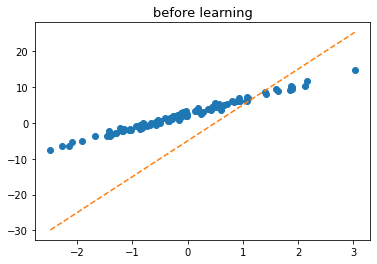

In [17]:
plt.plot(x, y , 'o')
plt.plot(x , net(X).data , '--')
plt.title("before learning" , size = 13)

In [21]:
## (2) 1회 갱신
optimizr = torch.optim.Adam(net.parameters() , lr = 0.1)
loss_fn = torch.nn.MSELoss()
loss = loss_fn(net(X) , y)
loss.backward()
optimizr.step()
net.weight.data # w0hat , w1hat 1회 갱신

tensor([[-4.9000,  9.9000]])

In [22]:
net.weight.grad ## (-5,10) 에서 미분계수

tensor([[-15.7290,  14.7198]])

In [23]:
## (3) 5회 갱신한 값
optimizr.zero_grad()

for epoc in range(4):
  loss = loss_fn(net(X) , y)
  loss.backward()
  optimizr.step()
  optimizr.zero_grad()

net.weight.data ## W0hat , W1hat 5회 갱신한 값

tensor([[-4.5006,  9.5008]])

In [24]:
## (4)
optimizr2 = torch.optim.SGD(net.parameters() , lr = 0.2)

for epoc in range(10):
  loss = loss_fn(net(X) , y)
  loss.backward()
  optimizr2.step()
  optimizr2.zero_grad()

net.weight.data ## W0hat , W1hat 10회 추가 갱신한 값

tensor([[2.4925, 3.9607]])

Text(0.5, 1.0, 'after learning')

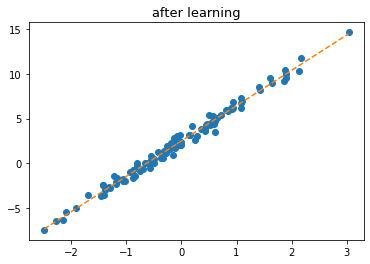

In [27]:
## (5)
plt.plot(x, y, 'o')
plt.plot(x, net(X).data , '--')
plt.title("after learning" , size = 13)

- 직선이 주어진 데이터를 잘 따라가고 있으므로 학습이 잘 되었다고 생각한다.
- 학습 후 최종 (w0hat , w1hat) = (2.4925, 3.9607) 이다. 

## `3`. 다음을 읽고 참 거짓을 판단하라. (20점)

`(1)` MNIST 이미지를 분석하였으므로 X는 흑백이미지의 형태로 저장되어 있을 것이다. 즉 텐서 의 shape은 (n,1,28,28) 과 같은 형태일 것이다.

In [47]:
# 거짓

`(2)` 손실함수는 torch.nn.CrossEntropyLoss 를 사용했을 것이다.

In [82]:
# 참

`(3)` 위의 코드는 resnet34를 이용한 transfer learning 을 구현하였다.

In [83]:
# 참

`(4)` 모두 GPU연산이 가능한 저장장치에 있다.

In [81]:
# 참

`(5)`  softmax함수를 취하게 되면 [0,1] 근처의 값이 나올것이다.

In [49]:
 # 거짓

----

`(6)` torch.nn.Linear(in_features=1,out_features=1,bias=True) 는 학습가능한 파라메터수가 2개이다.

In [76]:
# 참

`(7)` 아래 2개의 레이어에 대한 학습가능한 파레메터 수는 같다.

In [75]:
# 참

`(8)` 아래의 네트워크에서 K를 충분히 크게 설정하면 모든 1차원 연속함수를 원하는 정확도로 근사시킬 수 있다.

In [77]:
# 참

`(9)` torch.nn.Dropout(0.9)을 이용하여 생성된 layer는 10%의 layer input을 임의로 0으로 만든다.

In [78]:
# 거짓

`(10)` 아래와 같은 모형에서 자료가 생성되었다고  하자.
이 경우 다음과 같은 네트워크와 손실함수를 선택한다면 손실함수는 항상 convex function이 된다.

In [79]:
# 참